# 1. Definition of a problem statement and a short outline of the implementation

We have found a dataset containing data about students alcohol consumption, their grades and several social conditions.

Our problem statement is to find patterns as different groups of the students based on the features and compute a model that can predict if the students are bing or heavy drinker. 


Link to colab notebook: https://colab.research.google.com/drive/15ETOHyj6L8Lv8lej6tVbqit09RjP2cCE 

Link to Githup Rep: https://github.com/michaeldybdahl/M1_exam2019


## 1.2. Description of data acquisition / how it was collected

We found the data at kaggle.

Link: https://www.kaggle.com/joeycorea/mathportugeseyouthalcoholstudy 

Link (original dataset): https://www.kaggle.com/uciml/student-alcohol-consumption 

Link (our upload): https://raw.githubusercontent.com/michaeldybdahl/M1_exam2019/master/student_math_por_formatted.csv



*The dataset constist of 53 variables and 1044 observations.*


# 2. Load packages and dataset

We start with installing the pacman package for loading and checking packages easier and faster. 

In [0]:
set.seed(1337) # To have a seed defined for reproducability

if (!require("pacman")) install.packages("pacman") # package for loading and checking packages

Loading required package: pacman
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pacman’”Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Now we load all the packages, that we are going to use in this notebook.

In [0]:
pacman::p_load(tidyverse, magrittr, data.table,VIM,mice,FactoMineR, factoextra, GGally, caret, recipes, ranger, rpart.plot)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

data.table installed
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘zip’, ‘SparseM’, ‘MatrixModels’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘zoo’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘DEoptimR’, ‘lmtest’, ‘RcppEigen’, ‘car’, ‘robustbase’, ‘sp’, ‘vcd’, ‘e1071’, ‘laeken’, ‘ranger’


VIM installed
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘ucminf’, ‘numDeriv’, ‘ordinal’, ‘pan’, ‘jomo’, ‘mitml’


mice installed
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘ellipse’, ‘flashClust’, ‘leaps’, ‘scatterplot3d’


FactoMineR installed
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘viridis’, ‘ggsci’, ‘cowplot’, ‘gg

In [0]:
grade <- read_csv("https://raw.githubusercontent.com/michaeldybdahl/M1_exam2019/master/student_math_por_formatted.csv")

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


# 3. Data preparation


## 3.1. Data cleaning

We want to check if the dataset has any missing values.

In [0]:
sum(is.na(grade))

[1] 0

As we can see by summing the dataset with NA values, their are 0 cases. So therefor we dont need to clean the dataset concerning NA/Missing values. 

## 3.2. Recoding

We will encode the label to the observations ID from X1 (their was no label encoded by default). So we rename it from "X1" to "ID".

Concerning dummy variables, then the dataset is already coded with dummy variables. For example the father and mother jobs are already coded into dummy variables as "Mjob_at_home, Mjob_health" etc..

We want to change the type of the dummy variables from double to factors.

We wont need to merge or wrangle any data into the primary dataset. 

In [0]:
grade <- rename(grade, ID = X1) #renaming the "X1" coloumn to "ID"

In [0]:
names <- c(5:26,31:50) # we just define "names" as variables/coloumns 5 to 26 and 31 to 50.
grade[,names] <- lapply(grade[,names] , factor) # here we transform the variables format to factor.

We are going to use daily and weekly alcohol consumption (Dalc & Walc) as a numeric variable. Therefor we create two more variables, where we mutate these variables as numeric variables. 

Even the scale for the alcohol consumption are on ordinal scale (1-5), we consider them as useful for our unsupervised ML. 

In [0]:
grade <- grade %>%
  mutate(Dalc_num = as.integer(Dalc), Walc_num = as.integer(Walc)) # we create Dalc & Walc as integer variables

# 4. Exploratory data analysis

## 4.1. Relevant! summary statistics

Here we will look at how many observations the datasat has, how many Male and Female observations there are.

Then we will look at how many "bing" and "heavy drinker" there are, and last, how the average grade are overall and by gender. 

The dataset contain students from two schools (GP and MS). Here we will also compare the above statistics compared by the two schools. 

**Splitting up the dataset:**

In [0]:
grade_m <- grade %>%
  filter(sex == 1) # creating dataset only with male students (1 = male)

grade_f <- grade %>%
  filter(sex == 0) # creating dataset only with mfeale students (0 = female)

grade_GP <- grade %>%
  filter(school == 0) # creating dataset only with students from GP school (GP = 0)

grade_MS <- grade %>%
  filter(school == 1) # creating dataset only with students from MS school (MS = 0)

**Male and Females:**

In [0]:
sum(grade$sex==0)
sum(grade$sex==1)

[1] 591

[1] 453

So there are slightly more females than males, but the distribution of sex is almost equal (57%/43%).

**GP and MS:**

In [0]:
sum(grade$school==0)
sum(grade$school==1)

[1] 772

[1] 272

74% of the students from the dataset is represented from the GP school, so this is markedly the biggest of the two schools. 

**Bing drinkers:**

In [0]:
sum(grade$binge_drinker == 1)

[1] 120

So there are total 120 binge drinkers in the dataset, which is those people who drink in weekends, but not in the workdays. 

In [0]:
sum(grade_m$binge_drinker == 1)
sum(grade_f$binge_drinker == 1)

[1] 78

[1] 42

Around 2/3 of the binge drinkers is the males. 

In [0]:
sum(grade_GP$binge_drinker == 1)
sum(grade_MS$binge_drinker == 1)

[1] 95

[1] 25

Most of the binge drinkers are from the GP school, but this is of course connected with the higher amount of GP students.

**Heavy drinkers:**

In [0]:
sum(grade$heavy_drinker == 1)

[1] 42

So there are total 42 heavy drinkers in the dataset, which is those people who drink heavy both in weekends and workdays. 

In [0]:
sum(grade_m$heavy_drinker == 1)
sum(grade_f$heavy_drinker == 1)

[1] 37

[1] 5

Most of the heavy drinkers are males (88%) and only five females are heavy drinkers.

In [0]:
sum(grade_GP$heavy_drinker == 1)
sum(grade_MS$heavy_drinker == 1)

[1] 32

[1] 10

Most of the heavy drinkers are from the GP school, but again this is connected with the high amount of GP students in the dataset.

**Average grade:**

In [0]:
mean(grade$overall_grade)

[1] 11.28592

The average overall grade is 11,28 for all students.

In [0]:
max(grade$overall_grade)

[1] 19.5

The highest average overall grade is 19,5 where the grade scale's maximum is 20.

In [0]:
mean(grade_f$overall_grade)
mean(grade_m$overall_grade)

[1] 11.37352

[1] 11.17163

The average overall grade is slightly higher for the female students, but they are only 0,2 point higher than the male students.

In [0]:
max(grade_f$overall_grade)
max(grade_m$overall_grade)

[1] 18.75

[1] 19.5

Here we can see that the highest average overall grade is obtained from a male student, where the highest average is 18,75 for a female student. 

In [0]:
mean(grade_GP$overall_grade)
mean(grade_MS$overall_grade)

[1] 11.57707

[1] 10.45956

The average overall grade is markedly higher at the GP school, where it is more than 1 gradepoint higher. 

In [0]:
max(grade_GP$overall_grade)
max(grade_MS$overall_grade)

[1] 19.5

[1] 18.75

We can see that the highest grade is obtained from a GP student, who we know is a male.

## 4.2. Visualisations

In this section we will compute some relevant visualisations, for example how heavy drinkers are represented in the overall grades, how the mean overall grade is distributed by age, etc.

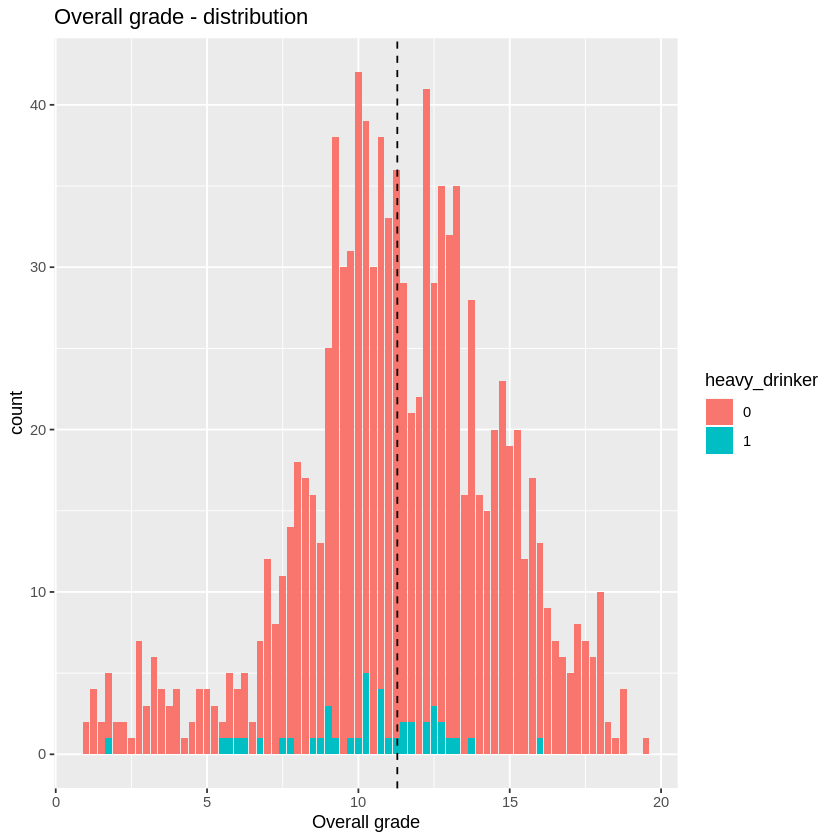

In [0]:
ggplot(grade,aes(overall_grade, fill = heavy_drinker))+ #add overall grade as x values and fill the values with "heavy drinker"
geom_bar()+ # we use the barplot
labs(title = "Overall grade - distribution", x = "Overall grade")+
geom_vline(xintercept = mean(grade$overall_grade), linetype = 2) # we add the line that represents the mean overall grade

It seems as the heavy drinkers are slightly more represented below the mean overall grade, and that there are not heavy drinkers with a high grade. On the other hand, it seems as there are not so many heavy drinkers with the lowest grades.

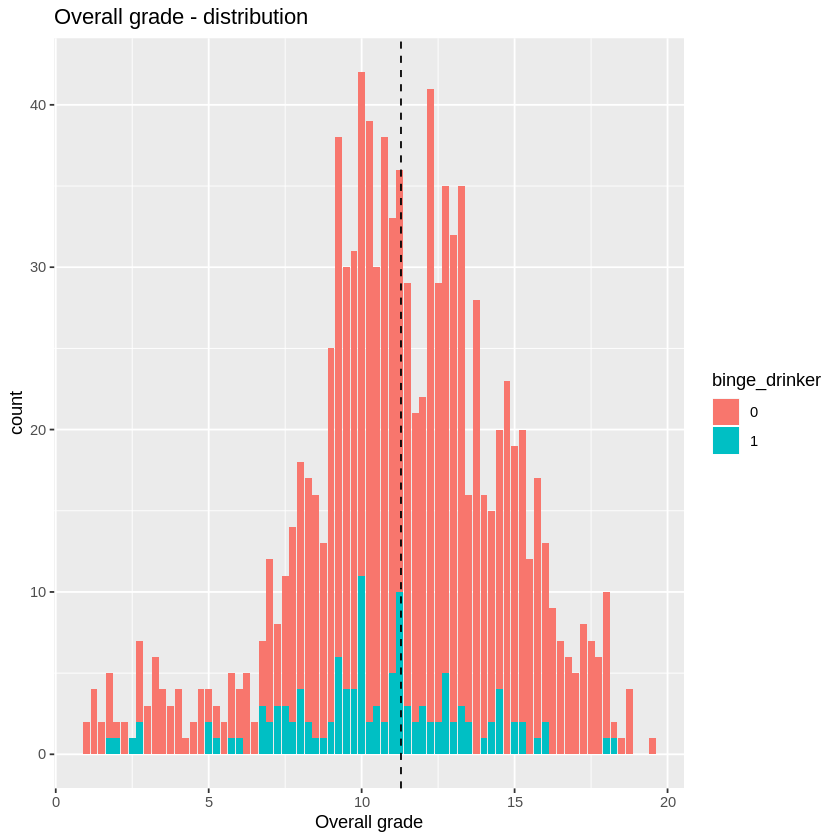

In [0]:
ggplot(grade,aes(overall_grade, fill = binge_drinker))+ 
geom_bar()+
labs(title = "Overall grade - distribution", x = "Overall grade")+
geom_vline(xintercept = mean(grade$overall_grade), linetype = 2)

By making a barplot filled with binge drinkers, we can see that the distribution for both those who are binge drinker and not, is almost the same. Maybe there are not that many binge drinkers with the highest grades, but around the average grade, the distribution almost looks like the same.

In [0]:
grade_mean <- grade %>%
    group_by(age) %>%
      summarize(mean_grade = mean(overall_grade))

Here we create a new dataframe only with the mean grades, grouped by the age, so that we can see if the age have a impact on the overall grade.

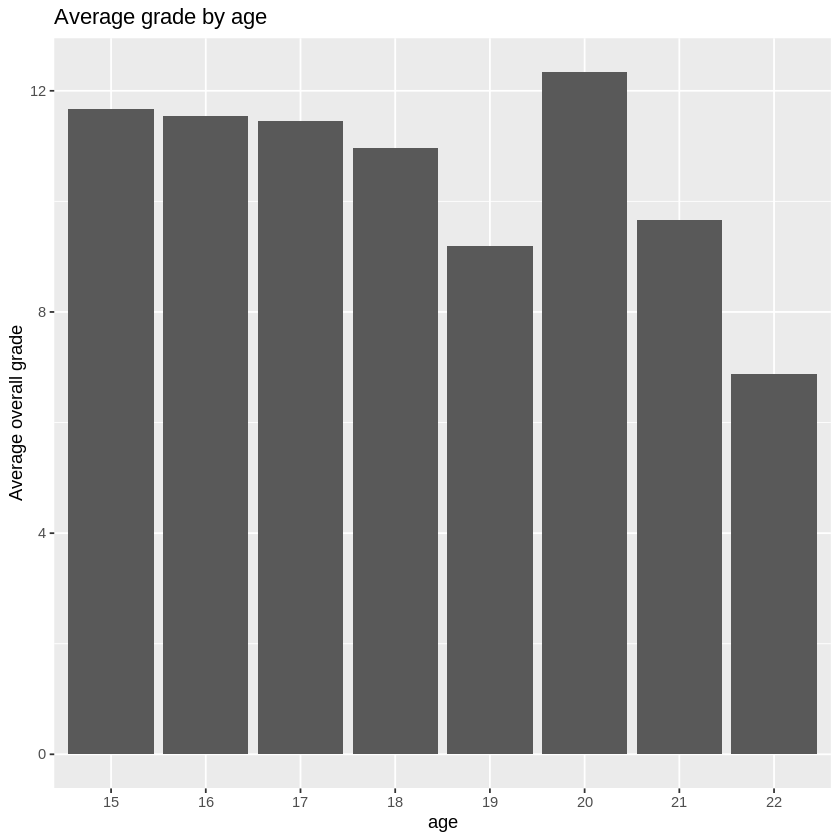

In [0]:
grade_mean %>%
  mutate(age = as.factor(age)) %>% # we mutate age as a factor, so we can create a barplot with age as x values
  ggplot(aes(age, mean_grade))+
geom_col()+ # we use geom_col, because we also wants y values to be included in the bar plot
labs(title = "Average grade by age", y = "Average overall grade")


We can see that students from 15-17 years and the 20 years old students, has a average overall grade around 11,5 - 12. The 19 and 21 years old students has a average overall grade around 9-10, and the 22 years old students has a the lowest overall grade, which is around 7. 

This could indicate that the older students maybe are those who previous has failed their exams and have trouble with passing the school or are tired of going to school. 

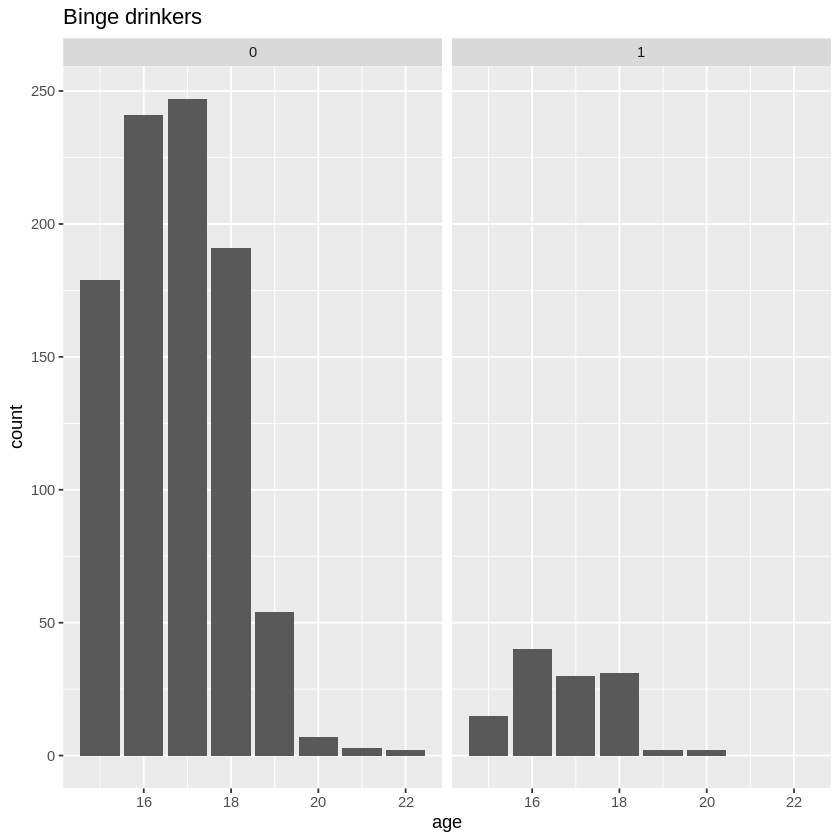

In [0]:
ggplot(grade, aes(age))+
geom_bar()+
labs(title = "Binge drinkers")+
facet_wrap(~binge_drinker)

Here we can see that most of the binge drinkers are the students from age 15 to 18 and with the previous two barblots, we can conclude that binge drinking does not really affect the grades. 

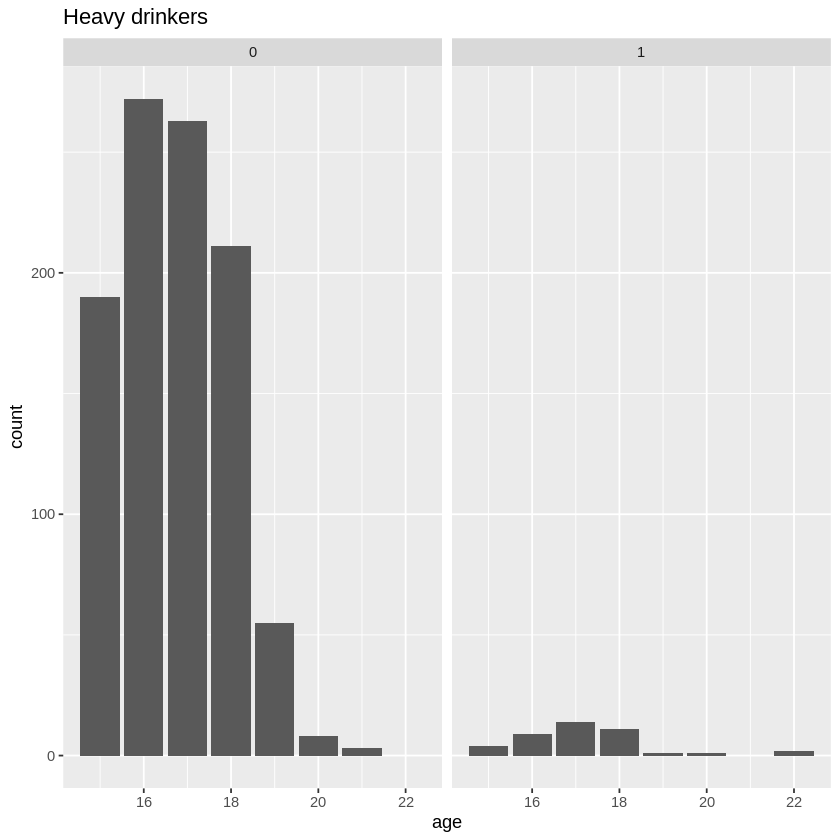

In [0]:
ggplot(grade, aes(age))+
geom_bar()+
labs(title = "Heavy drinkers")+
facet_wrap(~heavy_drinker)

Again we can see that most of the heavy drinkers are alsothe students from age 16 to 18, although with a couple heavy drinkers that are 20 and 22 years old. 

In [0]:
table(grade$binge_drinker, grade$age)

   
     15  16  17  18  19  20  21  22
  0 179 241 247 191  54   7   3   2
  1  15  40  30  31   2   2   0   0

Using the table function, we can see how many people that are binge drinker (1) compared with how many that are not (0).

We can see that most of the students are 15-18 years old and therefor it makes sence that most of the binge drinkers are represented by those ages. 

In [0]:
table(grade$heavy_drinker, grade$age)

   
     15  16  17  18  19  20  21  22
  0 190 272 263 211  55   8   3   0
  1   4   9  14  11   1   1   0   2

With this table, we can see that there are only 2 students that are 22 years old and both of those are heavy drinkers. 



# 5. Feature scaling

We are going to use the numeric variables: "age", "absences", "Dalc", "Walc", "G1-G3" and "overall_grade". 

**Scaling the numeric variables:**

The eight numeric variables are not on the same scale. For example the four grade variables are on same scale, but like "age" and "absences" are on another scale. Therefor we are scaling all the variables, so they get on the same scale.

In [0]:
grade_scaled <- grade %>%
  select(age, G1, G2, G3, overall_grade, absences, Walc_num, Dalc_num) %>% # we select the numeric variables.
    scale() # piping in the selected variables into the scale function. 

In [0]:
head(grade_scaled)

age,G1,G2,G3,overall_grade,absences,Walc_num,Dalc_num
1.0273971,-2.082729,-1.5969726,-1.3822086,-1.6512205,0.25203380,-0.9995160,-0.5421138
0.2209290,-2.082729,-1.9013800,-1.3822086,-1.7257890,-0.07002653,-0.9995160,-0.5421138
-1.3920072,-1.412352,-0.9881578,-0.3472251,-0.7563987,0.89615447,0.5567773,0.5547211
-1.3920072,1.269158,0.8382867,0.9465043,1.0332449,-0.39208686,-0.9995160,-0.5421138
-0.5855391,-1.747540,-0.3793430,-0.3472251,-0.6818302,-0.07002653,-0.2213693,-0.5421138
-0.5855391,1.269158,1.1426941,0.9465043,1.1078134,0.89615447,-0.2213693,-0.5421138


# 6. Unsupervised ML

## 6.1. Dimensionality reduction (PCA):

After having scaled the eight numeric variables, we can compute the PCA using the "PCA" function.
We chose to start with 6 components and therfor set the "ncp = 8", since we wanted to look at the PCA for all the variables, and thereby make a dimension reduction. We also add the argument "scale.unit = TRUE" since the data are scaled to unit variance.



In [0]:
grade_pca <- grade_scaled %>%
  PCA(ncp = 8, scale.unit = TRUE) 

After having computed the PCA, we make a Scree plot, to visualize how much variance is explained in the 6 dimensions. 



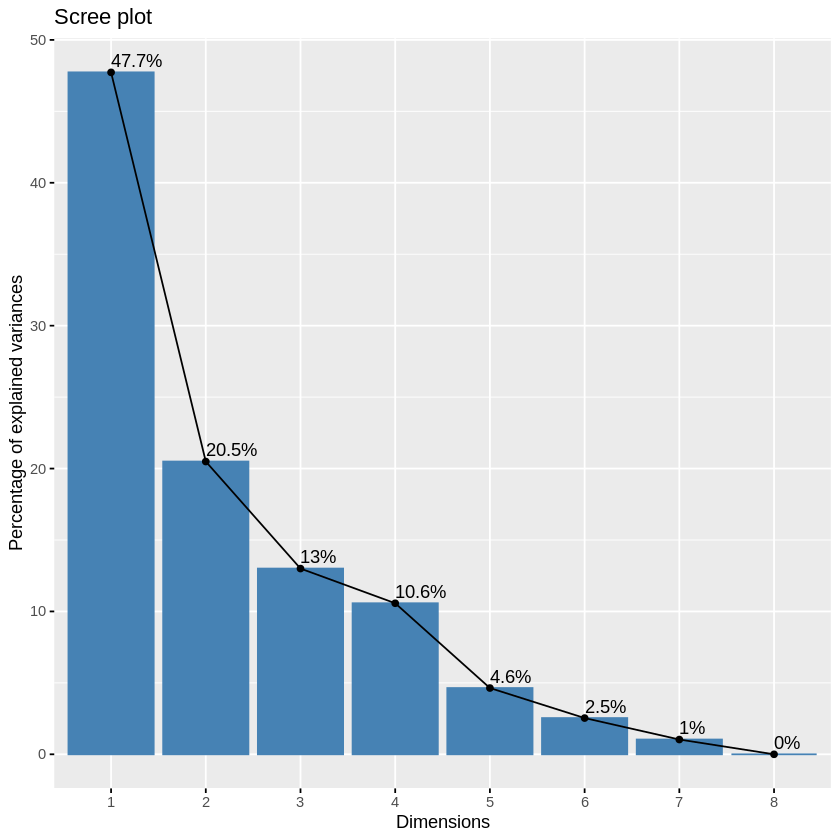

In [0]:
grade_pca %>%
  fviz_screeplot(addlabels = TRUE, # we want the % explained variance to be displayed as labels. 
                 ncp = 8, # we set ncp to 8, because we want to see all eight possible dimensions. 
                 ggtheme = theme_gray())

Here we look after the "bend", where the explained variance decrease, although we only use this as guideline, but not as a decisionmaker. 

By the scree plot, we consider that the PCA should have 3 dimensions, because it "bend" at 3 dimensions and with 4 dimensions, the explained variance "only" increase with 10,6%.

Now we use the eigenvalues to decide the number of dimensions, where we use our rule-of-thumb which says that we should include dimensions with eigenvalues > 1. 

In [0]:
grade_pca$eig %>% as_tibble()

eigenvalue,percentage of variance,cumulative percentage of variance
<dbl>,<dbl>,<dbl>
3.818200e+00,4.772749e+01,47.72749
1.639229e+00,2.049036e+01,68.21786
1.039989e+00,1.299986e+01,81.21771
8.457885e-01,1.057236e+01,91.79007
3.710562e-01,4.638202e+00,96.42827
2.029478e-01,2.536848e+00,98.96512
8.279027e-02,1.034878e+00,100.00000
6.788855e-32,8.486068e-31,100.00000


When we look at the eigenvalues, we see the eigenvalues for the first three dimensions is > 1, and the fourth is 0.84. Using the Scree plot and the eigenvalues we choose to reduce the dimension to three.

Now we want to look at the 2-dimensional space of the first two dimensions. At this plot we can see the contribution of the variables for the two first dimensions.

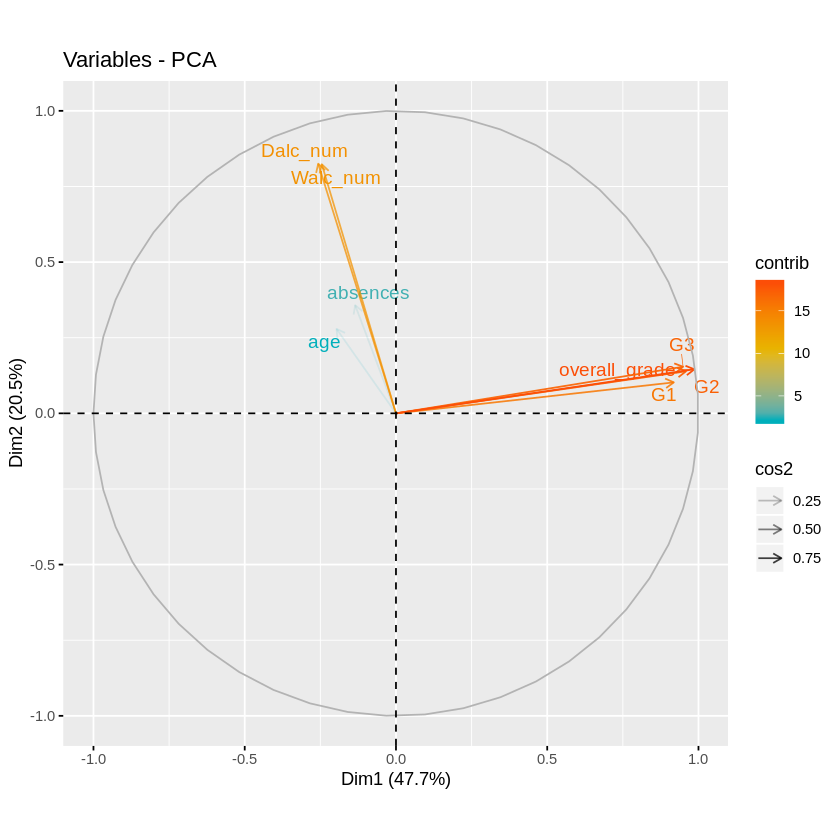

In [0]:
grade_pca %>%
  fviz_pca_var(alpha.var = "cos2",
               col.var = "contrib",
               gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
               repel = TRUE,
               ggtheme = theme_gray())

At the plot we see that all the grades, G1-G3 and overall_grades, has a high contribution at dimension one, and "Dalc" & "Walc" has a high contrubition to dimension two. We can also see that these two alcohol variables has a negativ contribution to dimension one, which makes sence, that alcohol affect the grades negative.

The age and absence variables are pretty faded, which indicate that they probably contribute more to dimension 3. 

Below we also see at the correlations between the variables and the dimensions, where we can see a high correlation (almost 1) between the grades and dimensionss 1. And that Dalc and Walc has a high correlation (around 0,82) with dimension 2. Then we can see that age and absence has a high correlation with dimension 3. 

The fact that the three grades and the overall_grade explains the same (can be reduced to 1 dimension), is not suprising, because the overall_grade is a average of the three period grades. 

In [0]:
grade_pca$var$cor

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8
age,-0.1964973,0.2790871,0.68445412,0.6436449588,0.027022552,-0.001956600,-0.002977316,-2.933125e-48
G1,0.9184084,0.1023907,0.01330368,0.0299411146,-0.001520250,0.376529204,-0.056498483,1.257831e-32
G2,0.9585203,0.1389663,0.01530888,0.0317103691,-0.007892969,-0.062443872,0.238171912,1.385022e-32
G3,0.9489894,0.1540589,0.03685079,-0.0125430731,0.005992318,-0.229847696,-0.145957998,3.258880e-32
overall_grade,0.9860998,0.1456172,0.02794994,0.0071991489,0.001182186,-0.064011558,-0.038353651,-5.654009e-32
absences,-0.1348981,0.3574497,0.65376386,-0.6528120457,-0.011370595,0.016344539,0.008064719,4.239643e-48
Walc_num,-0.2451667,0.8233577,-0.27961308,0.0002346308,0.428629395,0.007880624,0.002570799,-6.595000e-48
Dalc_num,-0.2570512,0.8251771,-0.25173410,0.0568762104,-0.431707764,0.003721506,-0.004132877,2.826429e-48


## 6.2. Clustering (KMeans):

In this section we are clustering based on the same numeric variables as we used in the PCA.

We will use KMeans as the clustering method.

In [0]:
grade_scaled_km <- grade %>%
  select(age, G1, G2, G3, overall_grade, absences, Dalc_num, Walc_num) %>%
    scale()

Before creating the clusters, we need to define how many clusters we want to be created.

Here we use a screeplot with the total WSS on the y-axis and clusters on the x-axis.

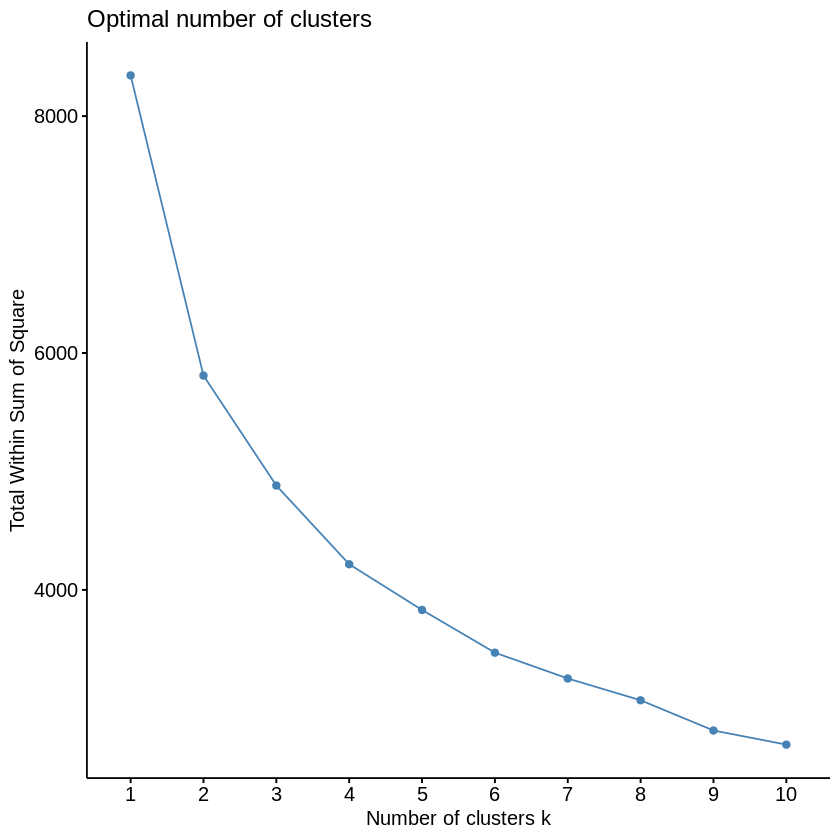

In [0]:
grade_scaled_km %>%
  fviz_nbclust(kmeans, method = "wss")

Looking at the screeplot, we consider using the "elbow" method, that the curve is bending from 4 to 5 clusters. Therefor we chose the numbers of clusters to be 4 and can now compute the clusters with kmeans.

We use "kmeans" function to create the clusters and create a new dataframe "grade_km".

In [0]:
grade_km <- grade_scaled_km %>%
  kmeans( centers = 4, nstart = 20) # centers = clusters, nstart = random sets to be chosen.

Now we are going to see what is inside the four clusters. Here we add a coloumn "cluster" to the grade dataframe, se we can group the data by the cluster and afterwards summarise it by the variables mean.

We also add a coloumn with the cluster's n (number of observations inside each cluster).

In [0]:
grade %>%
  bind_cols(cluster = grade_km$cluster) %>%
  select(age, G1,G2,G3,overall_grade,Dalc_num,Walc_num,cluster,absences) %>%
  group_by(cluster) %>%
  mutate(n = n()) %>%
  summarise_all(funs(mean))

cluster,age,G1,G2,G3,overall_grade,Dalc_num,Walc_num,absences,n
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,17.10656,7.049180,5.836066,4.065574,5.254098,1.303279,2.147541,3.442623,122
2,16.55819,10.515439,10.707838,11.057007,10.834323,1.137767,1.828979,4.287411,421
3,16.59561,14.598746,14.780564,15.175549,14.932602,1.203762,1.943574,3.043887,319
4,17.08791,9.686813,9.923077,10.159341,9.982143,2.956044,4.027473,7.879121,182


In [0]:
# We will use the variables mean to help evaluate the four clusters.
mean(grade$age)
mean(grade$absences)
mean(grade$overall_grade)
mean(grade$Dalc_num)
mean(grade$Walc_num)

[1] 16.72605

[1] 4.434866

[1] 11.28592

[1] 1.494253

[1] 2.284483

**Cluster 1:** This cluster contain students with the lowest grade, low alcohol consumption and low absence. So this is the less smart students, but still does an effort. It is also the oldest students based on the average, which could indicate that it is the students who have failed their first exams/periods.

**Cluster 2:** This cluster contain students with the average grade, low alcohol consumption and average absence. In general this must be average students.

**Cluster 3:** This cluster contain students with the high grades, low alcohol consumption and low absence. This must be the smart and ambitious students. 

**Cluster 4:** This cluster contain students with the around average grades, high alcohol consumption and high absence. So this is the students who drink allot both in workdays and weekends, and have a high absence (proably because they are hungover).



Now we try to plot the clusters into a 2 dimensional space, so we can see where the four clusters lay on the 2 first dimensions that we found in the PCA.

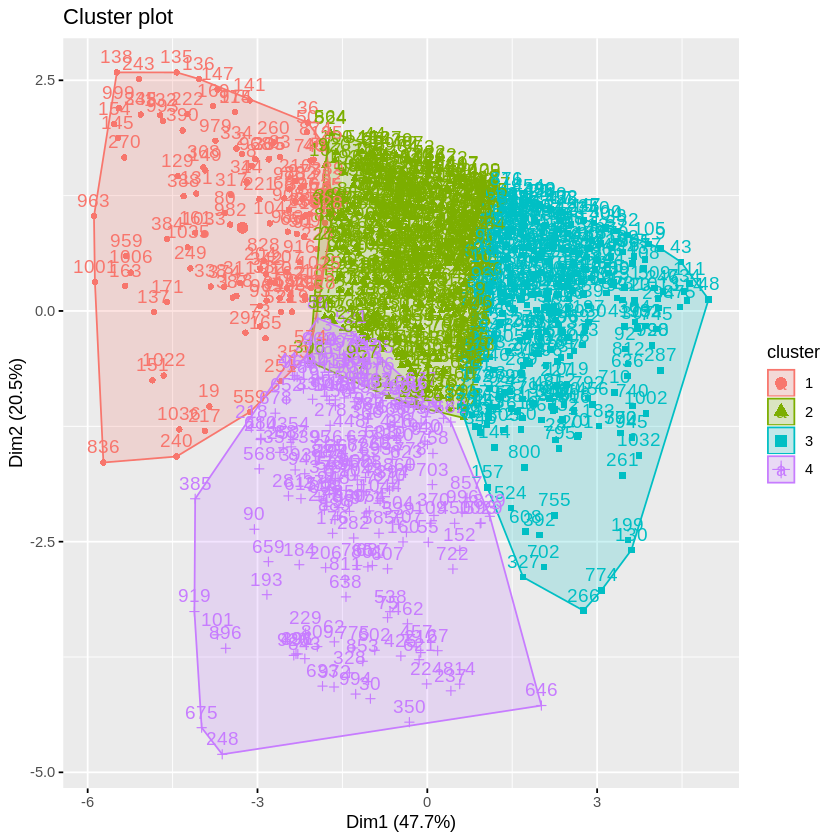

In [0]:
grade_km %>%
  fviz_cluster(data = grade_scaled,
               ggtheme = theme_gray()) 

Above we have plotted the clusters by the two first dimensions from the PCA. 

Here we can see that fx Cluster 4 lays around -3:0 on dim1, which indicates the average grade (abit lower than average). Also they lay below 0 on dim2, because of the high alcohol consumption. 

We can also see that cluster 1 and 3 are located on either sides of the dim1, which indicate the difference on their overall grades (cluster 1 = low grades).

# 7. Supervised ML

We are going to do machine learning first with a classification problem using logistic regression and decision tree. With the two classifications we want to predict if a student is heavy drinker or not. 

Afterwards we want to do machine learning with regression, where we want to predict the students overall_grade.

We split these two types of machine learning, so first we will present the calssifications and then the regression.

## 7.1. Classification of heavy drinkers

We now select the variables we are going to use in the classification. We do not use the "Walc" and "Dalc", since these may define if a student is heavy drinker or not and therefor are correlated. 

In [0]:
grade_C <- grade %>%
  select(school, sex, age, absences, health, romantic, Pstatus, Medu, Fedu, failures, goout, overall_grade, binge_drinker, heavy_drinker, G1, G2, G3) %>%
  mutate(heavy_drinker = as.logical(as.integer(heavy_drinker)-1L)) # we need heavy drinker to be logical

### 7.1.1. Train- / Testset preparation

First we split the data into a train- and testset, where we go for a 75%/25% split.

In [0]:
index <- createDataPartition(y = grade_C$heavy_drinker, p = 0.75, list = FALSE) # 75% to 25% split

trainingC <- grade_C[index,] #the training set with 75% of the data
testC <- grade_C[-index,] #the test set with 25% of the data

Below we preprocess the training data using recipes. 

In [0]:
reci <- recipe(heavy_drinker ~ ., data = trainingC) %>%
  step_dummy(all_nominal(), -all_outcomes()) %>% # create dummy variables for the nominal variables
  step_center(all_predictors(), -all_outcomes()) %>% # center predicting values to mean = 0.
  step_scale(all_predictors(), -all_outcomes()) %>% # scaling all the predicting variables to sd = 0.
  prep(data = trainingC)

reci

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         16

Training data contained 784 data points and no missing data.

Operations:

Dummy variables from health, romantic, Pstatus, Medu, Fedu, failures, ... [trained]
Centering for school, sex, age, absences, overall_grade, ... [trained]
Scaling for school, sex, age, absences, overall_grade, ... [trained]

In [0]:
# Predictors
x_trainC <-bake(reci, new_data = trainingC) %>% select(-heavy_drinker) #exclude heavy drinker from the x values
y_trainC <- trainingC %>% pull(heavy_drinker) %>% as.factor() # transform heavy drinker to be a factor.

# test: split in y and x
x_testC <-bake(reci, new_data = testC) %>% select(-heavy_drinker)
y_testC <- testC %>% pull(heavy_drinker) %>% as.factor()

### 7.1.2. Control workflow

In [0]:
ctrl <- trainControl(method = "cv", #define the ctrl method to cross validation.
                     number = 4, #number of folds (1044 / 261 = 4)
                      adaptive = list(min = 3, 
                        alpha = 0.05, 
                        method = "gls", 
                        complete = TRUE),
                      search = "random")

metric <- "Accuracy" # Assign which metric should be optimized.

### 7.1.3. Fitting the models

**Logistic regression model:**

Now we fit the logistic regreesion model, where we give the train function the arguments 

In [0]:
grade_fit_log <- train(x = x_trainC, #we define x.
                 y = y_trainC, # we define y.
                 trControl = ctrl, # we define the control workflow from above.
                 metric = metric, # we use a defined metric from above.
                 method = "glm", # we use "Generalized Linear Model" as method.
                 family = "binomial") # we define the distribution.

Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message

In [0]:
grade_fit_log

Generalized Linear Model 

784 samples
 30 predictor
  2 classes: 'FALSE', 'TRUE' 

No pre-processing
Resampling: Cross-Validated (4 fold) 
Summary of sample sizes: 588, 588, 588, 588 
Resampling results:

  Accuracy   Kappa    
  0.9566327  0.2696798


As we can see in the print of the fitted model, their are 30 predictors. This is because the reci part created dummy variables for the nominal variables, for example "Fedu" & "Medu".

The accuracy is 95,66%, which is pretty high, but we will look deeper into this later.

**Decision tree**

In [0]:
grade_fit_dt <- train(x = x_trainC, #we define x.
                 y = y_trainC, # we define y.
                 trControl = ctrl, # we define the control workflow from above.
                 metric = metric, # we use a defined metric from above.
                 tuneLength = 10, # the numbers of tuning rounds.
                 method = "rpart") # we use "rpart" as method which is a construction of a classification tree.

Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”

In [0]:
grade_fit_dt

CART 

784 samples
 30 predictor
  2 classes: 'FALSE', 'TRUE' 

No pre-processing
Resampling: Cross-Validated (4 fold) 
Summary of sample sizes: 588, 588, 588, 588 
Resampling results across tuning parameters:

  cp         Accuracy   Kappa    
  0.0000000  0.9579082  0.1820502
  0.0390625  0.9566327  0.1282744

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.

As we can see in the print of the fitted model, their are 30 predictors. This is because the reci part created dummy variables for the nominal variables, for example "Fedu" & "Medu".

The accuracy is 95,7%, which is pretty high, but we will look deeper into this later.

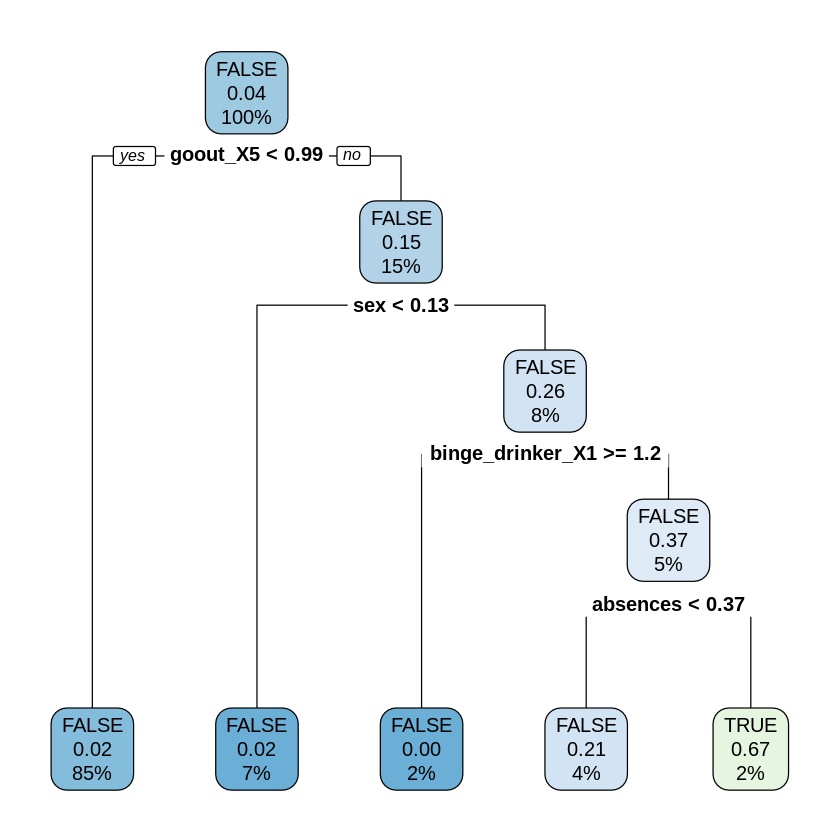

In [0]:
require(rpart.plot)

grade_fit_dt$finalModel %>% rpart.plot()

The tree plot above shows us that if you dont go alot out with friends, are male, is not a binge drinker and have high absence. Then there are 67% chance that you are a heavy drinker. 

At the same time we can see that there are 2% chance that a student is a heavy drinker, if the condition "going out with friends" is below very high, which applies to 85% of the students. 

In [0]:
table(grade_km$cluster, grade$sex)

   
      0   1
  1  82  40
  2 268 153
  3 192 127
  4  49 133

In the tree plot above, men had higher chance for being heavy drinkers and the table confirms this, because it shows that cluster 4(those who drink alot) is represented with mainly men.

### 7.1.4. Predicting and evaluating models

After having constructed and fitted the two models, we now want to predict heavy drinkers using the test set.

In [0]:
pred_log <- predict(grade_fit_log, newdata = x_testC) # apply predict to the fitted model and the test data
pred_dt <- predict(grade_fit_dt, newdata = x_testC) # apply predict to the fitted model and the test data

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”

We now check if the amount of predicted heavy drinkers is equal the the amount in the "y_testC".

In [0]:
print("Numbers of TRUE/FALSE values in the test set:")
summary(y_testC) 

print("Numbers of predicted TRUE/FALSE values using logitic regression:")
summary(pred_log)

print("Numbers of predicted TRUE/FALSE values using decision tree:")
summary(pred_dt)

[1] "Numbers of TRUE/FALSE values in the test set:"


FALSE  TRUE 
  250    10

[1] "Numbers of predicted TRUE/FALSE values using logitic regression:"


FALSE  TRUE 
  247    13

[1] "Numbers of predicted TRUE/FALSE values using decision tree:"


FALSE  TRUE 
  254     6

When we compare the result from above, we see that there are 10 "heavy_drinkers" in the "y_testC" (The true values). The Logistic model predicts 13 and the decision tree predicts six "heavy_drinkers. 

We now want to have a closer look into the result, by making a confusion matrix. Thereby we can conclude if the models are performing well. 

**Performance evaluation:**

In [0]:
confusionMatrix(pred_log, y_testC, positive = 'TRUE')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE   240    7
     TRUE     10    3
                                          
               Accuracy : 0.9346          
                 95% CI : (0.8974, 0.9615)
    No Information Rate : 0.9615          
    P-Value [Acc > NIR] : 0.9874          
                                          
                  Kappa : 0.2273          
                                          
 Mcnemar's Test P-Value : 0.6276          
                                          
            Sensitivity : 0.30000         
            Specificity : 0.96000         
         Pos Pred Value : 0.23077         
         Neg Pred Value : 0.97166         
             Prevalence : 0.03846         
         Detection Rate : 0.01154         
   Detection Prevalence : 0.05000         
      Balanced Accuracy : 0.63000         
                                          
       'Positive' Class : TRUE            
                     

The confusion matrix for the logistic model shows us that even it has a high accuracy, it does not perform well, because it only predict 30% heavy drinkers correct. We can see this because the model predict 13 as heavy drinkers, where 10 of them was FALSE and 3 was TRUE.

In [0]:
confusionMatrix(pred_dt, y_testC, positive = 'TRUE')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE   246    8
     TRUE      4    2
                                          
               Accuracy : 0.9538          
                 95% CI : (0.9208, 0.9759)
    No Information Rate : 0.9615          
    P-Value [Acc > NIR] : 0.7953          
                                          
                  Kappa : 0.2277          
                                          
 Mcnemar's Test P-Value : 0.3865          
                                          
            Sensitivity : 0.200000        
            Specificity : 0.984000        
         Pos Pred Value : 0.333333        
         Neg Pred Value : 0.968504        
             Prevalence : 0.038462        
         Detection Rate : 0.007692        
   Detection Prevalence : 0.023077        
      Balanced Accuracy : 0.592000        
                                          
       'Positive' Class : TRUE            
                     

The confusion matrix for the decision tree shows us that even it has a high accuracy, it performs worse than the logistic model, because it predict 20% heavy drinkers correct. We can see this because the model predict six as heavy drinkers, where 4 of them was FALSE and 2 was TRUE. 

## 7.2. Regression

In this section we are going to use regression to predict the overall grade by several variables.

First we start by creating a new dataframe, where we select the variables that we want to use in the regression model.

Here we have selected several relevant variables, to predict the overall grade.

In [0]:
grade_R <- grade %>%
  select(school, sex, age, absences, health, romantic, Pstatus, Medu, Fedu, failures, goout, overall_grade, binge_drinker, heavy_drinker, Walc, Dalc)

Before we ran the regression model, we knew that many of the variables would be insignificant.

Therefor we reduced the model with the variables with the highest p-value, step by step. This gave us a reduced model only including the variables: 

"school",  "romantic", "failures", "overallgrade" & "binge_drinker".

In [0]:
grade_R <- grade %>%
  select(school, romantic, failures, overall_grade, binge_drinker)

### 7.2.1. Train- / Testset preparation

First we split the data into a train- and testset, where we go for a 75%/25% split.

In [0]:
index_R <- createDataPartition(y = grade_R$overall_grade, p = 0.75, list = FALSE) # 75% to 25% split

trainingR <- grade_R[index_R,] #the training set with 75% of the data
testR <- grade_R[-index_R,] #the test set with 25% of the data

In [0]:
reci2 <- recipe(overall_grade ~ ., data = grade_R) %>%
  step_center(all_numeric(), -all_outcomes()) %>% # Centers all numeric variables to mean = 0
  step_scale(all_numeric(), -all_outcomes()) %>% # scales all numeric variables to sd = 1
  step_zv(all_predictors())  # Removed predictors with zero variance


# knn inputation of missing values
reci2 %<>%
  step_knnimpute(all_predictors()) 

# Recipe in the end has to be prepared on the treining data
reci2 %<>% 
  prep(data = trainingR)

reci2

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Training data contained 1044 data points and no missing data.

Operations:

Centering for school [trained]
Scaling for school [trained]
Zero variance filter removed no terms [trained]
K-nearest neighbor imputation for romantic, failures, binge_drinker, school [trained]

In [0]:
# Training: split in y and x
x_trainR <-bake(reci2, new_data = trainingR) %>% select(-overall_grade, ) # exclude the predicting variable
y_trainR <- trainingR %>% pull(overall_grade) # we include overall grade as the predicting variable

# test: split in y and x
x_testR <-bake(reci2, new_data = testR) %>% select(-overall_grade) 
y_testR <- testR %>% pull(overall_grade)

### 7.2.2. Control workflow

Here we define the control workflow for the regression model.

In [0]:
ctrl <- trainControl(method = "cv", #define the ctrl method to cross validation.
                     number = 4, #number of folds (1044 / 261 = 4)

### 7.2.3. Fitting the model

Now we fit the regression model, where we give the train function the arguments. 

In [0]:
fit_lm <- train(x = x_trainR, 
                y = y_trainR, 
                trControl = ctrl, # the predefined control workflow. 
                method = "glm", # we use "Generalized Linear Model" as method.
                family = "gaussian") # we define the distribution (gaussion = normal distribution)

Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”

### 7.2.4. Predicting and evaluating models

In this section we evaluate the performance of the fitted model. 

We will look at the RMSE and the coefficients, to evaluate how well the model are. 

In [0]:
fit_lm

Generalized Linear Model 

784 samples
  4 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 627, 628, 627, 626, 628 
Resampling results:

  RMSE      Rsquared   MAE     
  2.983057  0.1962148  2.300738


**Rsquared = 19,62%**: This means that the model explains 19,62% of the variance, which we consider not that high.

**RMSE:** The RMSE are 2,98, which means that the model in general predicts the grades 2,98 wrong. This we consider to be pretty high, which again is connected with the low explained variance. So we need a much higher Rsquared, to reduce the RMSE and make better  predictions of the grade.

In [0]:
fit_lm %>% summary()


Call:
NULL

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-10.8592   -1.6294    0.1206    1.9969    7.4637  

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     12.1795     0.1463  83.251  < 2e-16 ***
school          -0.3030     0.1095  -2.768  0.00578 ** 
romantic1       -0.4799     0.2250  -2.132  0.03328 *  
failures1       -3.1863     0.3298  -9.662  < 2e-16 ***
failures2       -3.5118     0.6510  -5.395 9.13e-08 ***
failures3       -4.7338     0.6496  -7.287 7.81e-13 ***
binge_drinker1  -0.8829     0.3216  -2.745  0.00618 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 8.880753)

    Null deviance: 8657.5  on 783  degrees of freedom
Residual deviance: 6900.3  on 777  degrees of freedom
AIC: 3946

Number of Fisher Scoring iterations: 2


In the summary we can see that all the included variables are significant (P value < 0.05).

**The coefficients:**


*   **Intercept = 12,1795**: So the grade intercept at 12,17.
*   **romantic1 = -0,4799:** So the grade decrease with 0,48 if your are in a relationship (a student prob use more time on relationship and lesser time on school)

*   **failures1 = -3,1863**: The grade decrease with 3,18 if you fail your class 1 time.
*   **failures2 = -3,5118**: The grade decrease with 3,5118 if you have failed your class two times.
*   **failures3 = -4,7338**: The grade decrease with 4,7338 if you have failed your class three times.
*   **binge_drinker1 = -0,8829**: The grade decrease with 0,8829 if you are a binge drinker.


Using this model to predict the overall grade is probably not that good, cause with all the coefficients that have a negative sign, it means that the grade cant be predicted higher than 12,1795 (intercept). The reason behind this is of course, that the model does not explain 



In [0]:
pred_lm <- predict(fit_lm, newdata = x_testR)

In [0]:
# RMSE OLS
sqrt(mean((y_testR-pred_lm)^2))

[1] 3.136744

Again, we can see that the RMSE is high and that the model does not performance very well. 

# 8. Conclusion



We found this dataset with Portuguese students and their alcohol consumption as well as further social conditions, which included 1044 students and 53 variables. 



**Exploratory data analysis:**

First we made a exploratory data analysis, where we examined the average overall grade based on gender and school, and how the alcohol affacted the grades.

We could see that the average overall grade was 11,28 and that females average grade was a bit higher then males. Also the GP school had markedly higher grades than MS and also most of the students went on GP.

We looked at some visualisations, where we could see that the binge and heavy drinkers had almost the same distribution as those who wasn't binge or heavy drinkers, although the drinkers was not really represented in the highest grades. 

We also looked at how the grades where distributed by the age, where the older students had lower grades than the younger students, which may because this students have had trouble by passing their classes.


**Unsupervised ML:**

As we computed unsupervised machine learning on the data, we could see by the PCA, that the numeric variables could be reduced to three dimensions. These dimensions explained the grades, the alcohol consumption and the absence & age.

Then we found four clusters using Kmeans, where these clusters contained the bad students, the average students, the good students and the students with high alcohol consumption.

**Supervised ML:**

After the unsupervised ML, we would try to predict if a student was a heavy drinker or not, using two models: logistic regression & decision tree. These models did not performed well, when predicting if a student was a heavy drinker, which proably is because the low number of heavy drinkers in the dataset. 

We also computed a regression model, which should predict the overall grade. This model included five response variables, which gave a Rsquared on 19,62% and RMSE around 3, which we considered as not that good. If the model should performe better, it need more explanatory variables, which could increase the Rsquared (explained variance) and reduce the RMSE, so the predictions would be better.
